<a href="https://colab.research.google.com/github/MickeyLeewells2020/Magic-The-Gathering-Rares-/blob/master/MTG_project_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!pip install category_encoders
!pip install pandas-profiling==2.*
! pip install pdpbox
! pip install shap
!pip install eli5

In [0]:
import pandas as  pd
import numpy as np
import plotly.express as px 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from scipy.stats import uniform
import category_encoders as ce
from xgboost import XGBRFClassifier ,XGBClassifier
from pandas_profiling import profile_report
from pdpbox.pdp import pdp_isolate, pdp_plot ,pdp_interact, pdp_interact_plot
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.metrics import accuracy_score
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.linear_model import  LinearRegression

In [0]:
mtg_c = pd.read_csv('/content/mtg_c.csv',index_col=0)

In [0]:

# mtg_c['rarity'] = mtg_c['rarity'].replace(1,'common')
mtg_c['rarity'] = mtg_c['rarity'].replace(2,1)
mtg_c['rarity'] = mtg_c['rarity'].replace(3,2)
mtg_c['rarity'] = mtg_c['rarity'].replace(4,2)

In [60]:
mtg_c['rarity'].value_counts(normalize=True)

1    0.652127
2    0.347873
Name: rarity, dtype: float64

In [61]:
mtg_c.head()

released_at mana_cost  cmc  ... loyalty oracle_text_count name_text_count
0  2020-12-30    {2}{R}  3.0  ...    -1.0                57               7
1  2020-12-30    {3}{R}  4.0  ...    -1.0               176              14
2  2020-12-30    {1}{U}  2.0  ...    -1.0                81              10
3  2020-12-30    {1}{W}  2.0  ...    -1.0                15               6
4  2020-07-31       {1}  1.0  ...    -1.0               226              11

[5 rows x 22 columns]

In [63]:
mtg_c.shape

(50254, 22)

In [30]:
mtg_c.dtypes

released_at           object
mana_cost             object
cmc                  float64
type_line             object
colors                object
color_identity        object
reserved                bool
reprint                 bool
set                   object
set_name              object
set_type              object
collector_number      object
digital                 bool
rarity                 int64
border_color          object
edhrec_rank          float64
power                float64
toughness            float64
promo_types           object
loyalty              float64
oracle_text_count      int64
name_text_count        int64
dtype: object

In [31]:
mtg_c.profile_report()

In [32]:
px.scatter(mtg_c, x= 'rarity', y='edhrec_rank')

In [0]:
target='rarity'
features = mtg_c.columns.drop(target)

In [0]:
train = mtg_c
test = train[features]
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['rarity'], random_state=17)


def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()


    
    

    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [0]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(),
    RandomForestClassifier(random_state=17,) 
)

param_distributions = {
    'randomforestclassifier__n_estimators': range(50, 500), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None], 
    'randomforestclassifier__max_features': uniform(0, 1), 
    'randomforestclassifier__min_samples_leaf': [10, 100, 1000]
}

In [37]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['released_at', 'mana_cost', 'type_line',
                                      'colors', 'color_identity', 'set',
                                      'set_name', 'set_type',
                                      'collector_number', 'border_color',
                                      'promo_types'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'released_at',
                                          'data_type': dtype('O'),
                                          'mapping': 2001-04-11      1
2...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                   

In [38]:
pipeline.score(X_val,y_val)

0.9076708785195503

In [39]:
y_val

12683    1
41523    1
16341    2
26028    1
4893     2
        ..
43914    1
33965    2
42233    1
41905    1
24157    1
Name: rarity, Length: 10051, dtype: int64

In [40]:
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['released_at', 'mana_cost', 'type_line',
                                      'colors', 'color_identity', 'set',
                                      'set_name', 'set_type',
                                      'collector_number', 'border_color',
                                      'promo_types'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'released_at',
                                          'data_type': dtype('O'),
                                          'mapping': 2001-04-11      1
2...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                   

In [41]:
%time
# refittiing original model after  re engineering data
search.fit(X_train,y_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.0min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=['released_at',
                                                                   'mana_cost',
                                                                   'type_line',
                                                                   'colors',
                                                                   'color_identity',
                                                                   'set',
                                                                   'set_name',
                                                                   'set_type',
                                                                   'collector_number',
                                                                   'border_color',
                                     

In [42]:
search.best_score_

0.8439419943785289

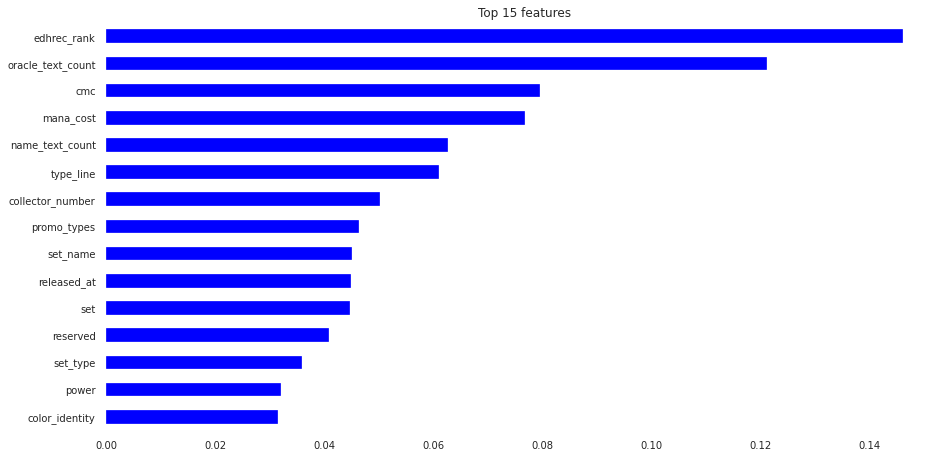

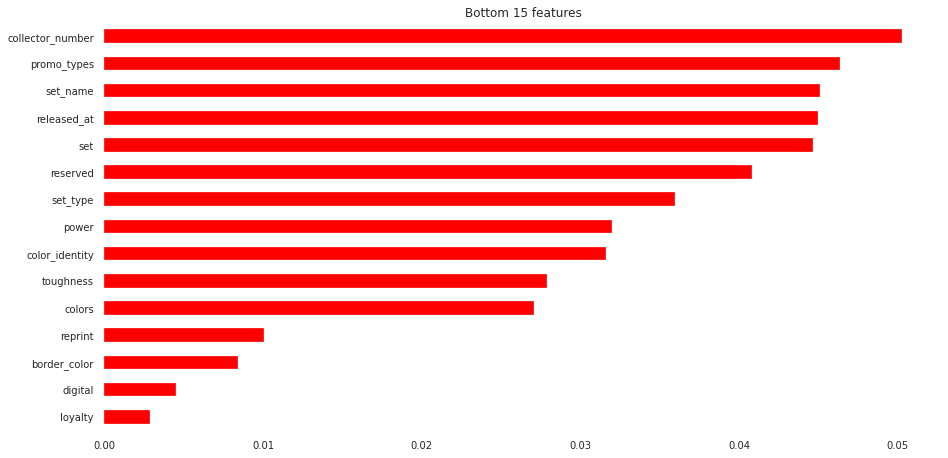

In [43]:
mt = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(mt.feature_importances_, X_train.columns)

n = 15
plt.figure(figsize = (15, n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='blue')

n = 15
plt.figure(figsize = (15, n/2))
plt.title(f'Bottom {n} features')
importances.sort_values()[:n].plot.barh(color='red');

In [44]:
mtg_c['rarity'].value_counts(normalize=True)

1    0.652127
2    0.347873
Name: rarity, dtype: float64

In [72]:
gb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=200, n_jobs=-1, booster='gbtree',learning_rate=.5)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting accuracy', accuracy_score(y_val, y_pred))

Gradient Boosting accuracy 0.8833946870958114


In [0]:
plt.rcParams['figure.dpi'] = 72

feature = 'edhrec_rank'

isolated = pdp_isolate(
    model=gb,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


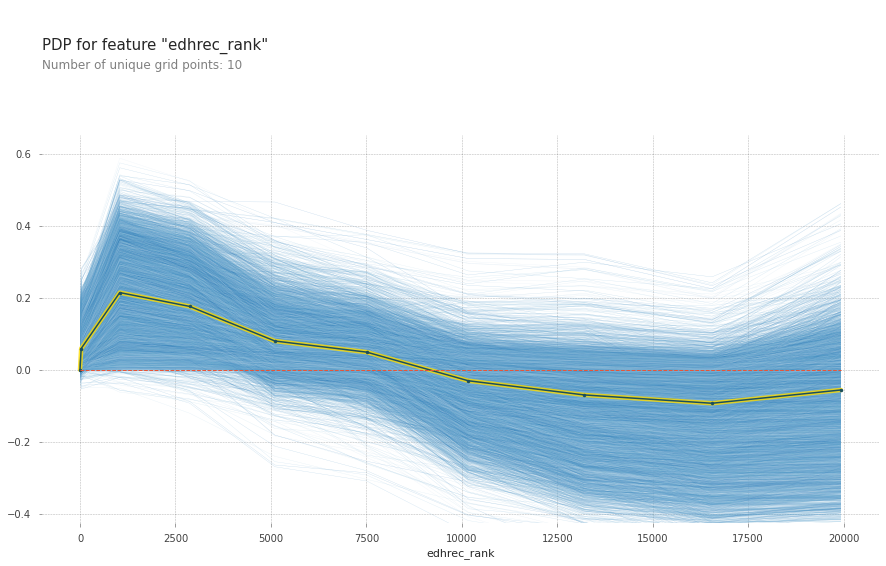

In [47]:
pdp_plot(isolated, feature_name=feature , plot_lines=True);

In [0]:
features = ['oracle_text_count', 'edhrec_rank']

interaction = pdp_interact(
    model=gb,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f5596ce00f0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f559695a5f8>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


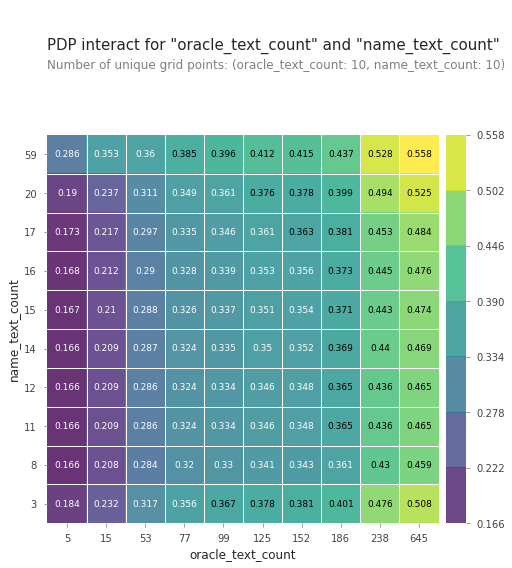

In [49]:
pdp_interact_plot(interaction, plot_type='grid',
                  feature_names=features)

In [0]:
features = ['edhrec_rank', 'oracle_text_count']

interaction = pdp_interact(
    model=gb,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f5596d18ac8>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f55a02c9f28>})

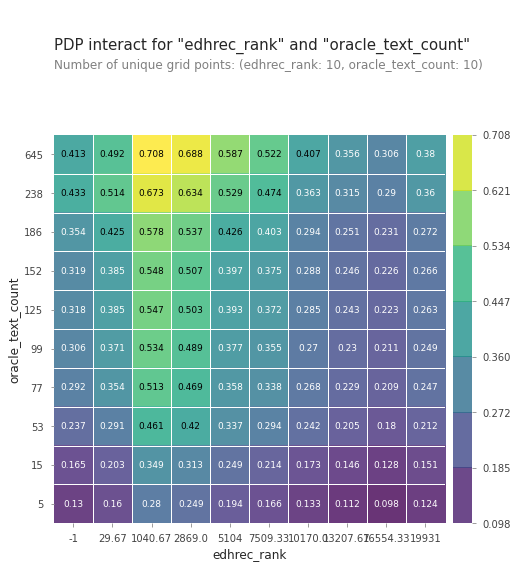

In [51]:
pdp_interact_plot(interaction, plot_type='grid',
                  feature_names=features)

In [52]:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [53]:
%%time
permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=30, 
    random_state=17  
)

permuter.fit(X_val_transformed, y_val)

CPU times: user 3min 19s, sys: 5.78 s, total: 3min 25s
Wall time: 2min 9s


In [0]:
# Per

In [55]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(
    ascending=False)

edhrec_rank          0.099459
cmc                  0.070633
oracle_text_count    0.056608
mana_cost            0.048098
reserved             0.030179
promo_types          0.025294
type_line            0.025065
name_text_count      0.023301
power                0.014214
color_identity       0.012937
toughness            0.010921
colors               0.009860
set_type             0.008328
set                  0.004786
set_name             0.003701
border_color         0.002620
released_at          0.002418
collector_number     0.001463
digital              0.000461
loyalty              0.000391
reprint             -0.000093
dtype: float64

In [56]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names,
    
)